# SMOTEbook - Checking the Effects of SMOTE

## Imports

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [4]:
wine_df = pd.read_csv("../winequality.csv")

# Fill missing data with either random data or a category corresponding to "Unknown"
for column in wine_df.columns:
    if wine_df[column].isna().any() and pd.api.types.is_numeric_dtype(wine_df[column]):
        wine_df.loc[wine_df[column].isna(), column] = [i for i in np.random.choice(range(round(wine_df[column].min()), round(wine_df[column]. max())), wine_df[column].isna().sum())]
    elif wine_df[column].isna().any() and (pd.api.types.is_object_dtype(wine_df[column]) or pd.api.types.is_categorical_dtype(wine_df[column])):
        wine_df[column].fillna("Unknown")

# Check for duplicates and drop duplicates
wine_df.drop_duplicates(inplace=True)
wine_df.reset_index(drop=True, inplace=True)

# Transform categorical variables into numerical variables
for column in wine_df.columns:
    if pd.api.types.is_categorical_dtype(wine_df[column]) or pd.api.types.is_object_dtype(wine_df[column]):
        one_hot = pd.get_dummies(wine_df[column], prefix=column)
        wine_df = wine_df.drop(column, axis = 1)
        wine_df = wine_df.join(one_hot)

# One-hot encode wine type
for column in wine_df.columns:
    if pd.api.types.is_categorical_dtype(wine_df[column]) or pd.api.types.is_object_dtype(wine_df[column]):
        one_hot = pd.get_dummies(wine_df[column], prefix=column)
        wine_df = wine_df.drop(column, axis = 1)
        wine_df = wine_df.join(one_hot)

# Get correlations within the features
features = wine_df.loc[:, wine_df.columns != 'quality']
cor = abs(features.corr())

# Get only upper half of the symmetric correlation matrix
feature_cor_upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))

# Exclude features with a correlation coefficient that is higher than 0.7 to at least one other feature
features_to_exclude = [column for column in feature_cor_upper.columns if any(feature_cor_upper[column] > 0.7)]

# Find features to be kept
features_to_be_kept = [feature for feature in wine_df.columns if feature not in features_to_exclude]

# Drop features: drop all features that show a low correlation with the target variable and that are highly intercorrelated
for column in wine_df.columns:
    if column not in features_to_be_kept:
        wine_df.drop(column, axis=1, inplace=True)


# Initially, target values range from 3 to 9; we bin them into 5 categories and relabel them from 0 to 4
# 0-3: Very Bad (0) = 1 stars, 4: Bad (1) = 2 stars, 5: Mediocre (2) = 3 stars, 6-7: Good (3) = 4 stars, 8-10: Very Good (4) = 5 stars
wine_df['quality'] = [0 if x < 4  else 1 if x==4 else 2 if x==5 else 3 if x <8  else 4 for x in wine_df['quality']]

## EDA before SMOTE

In [5]:
wine_df["quality"].value_counts()

3    3184
2    1755
1     206
4     154
0      30
Name: quality, dtype: int64

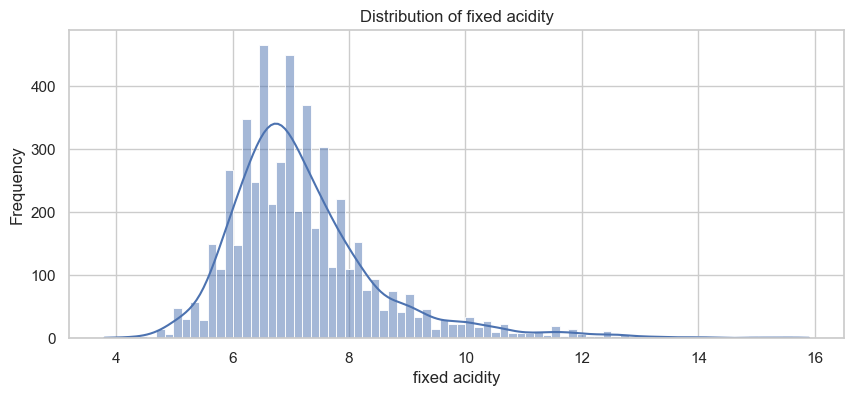

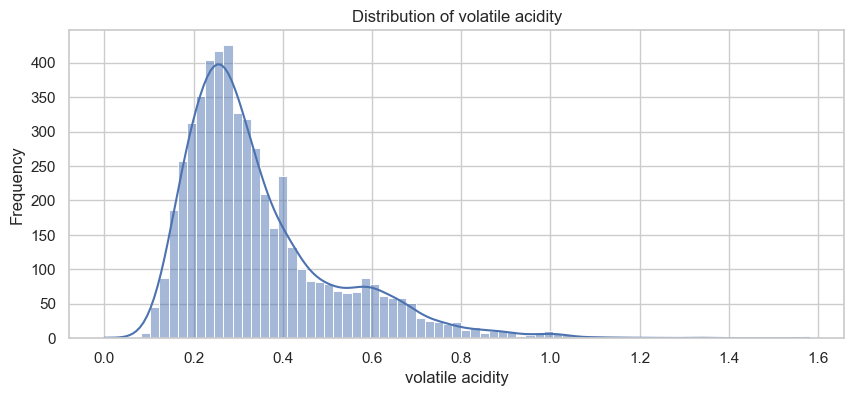

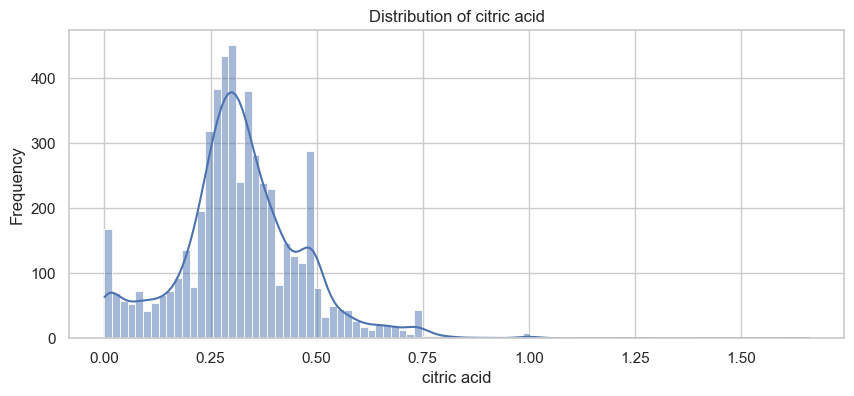

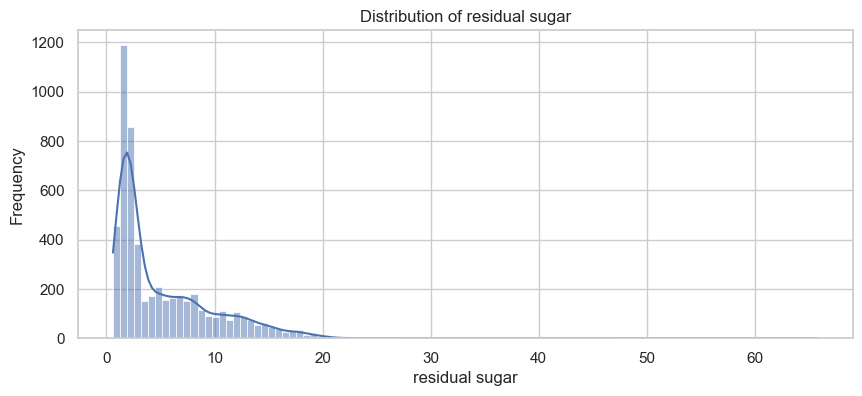

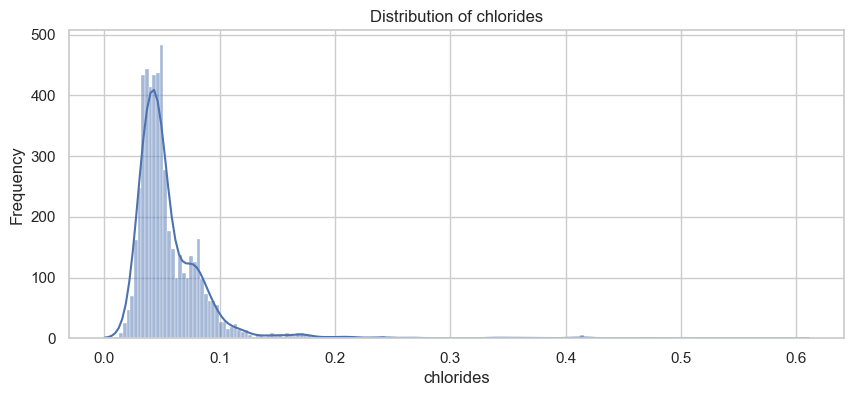

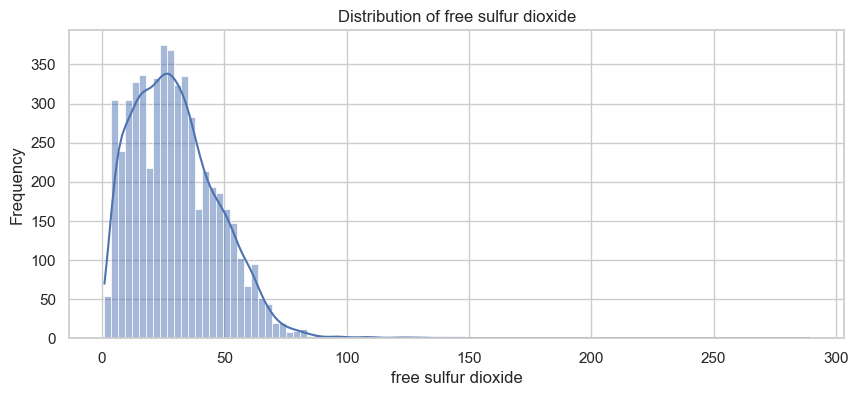

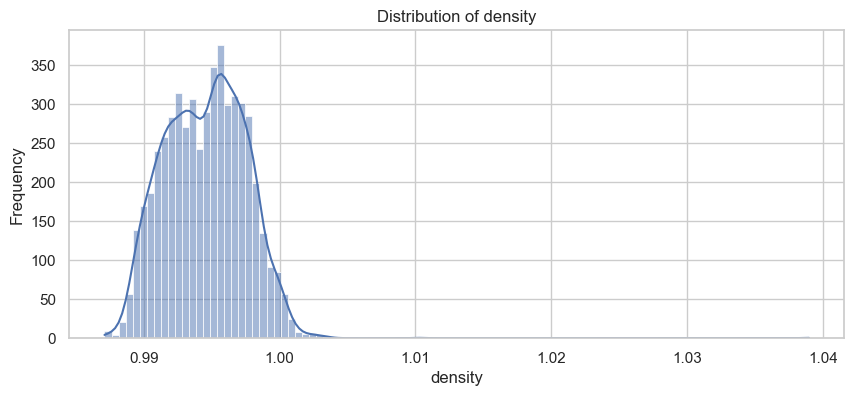

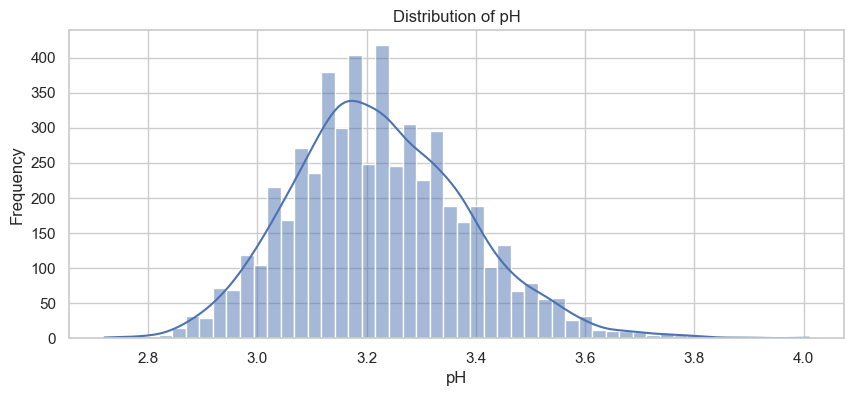

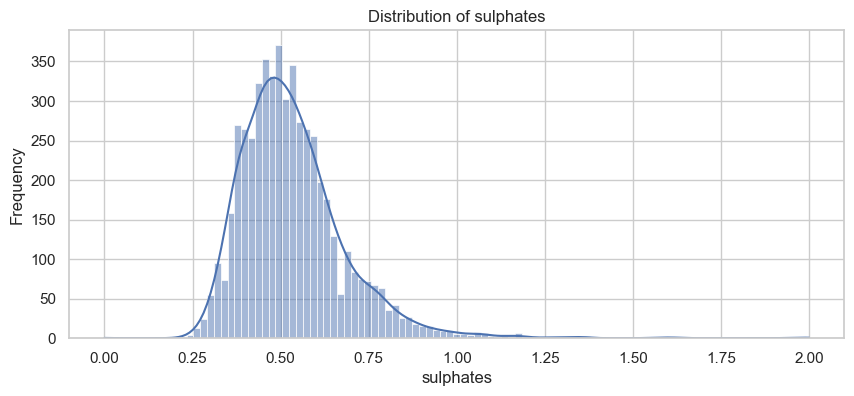

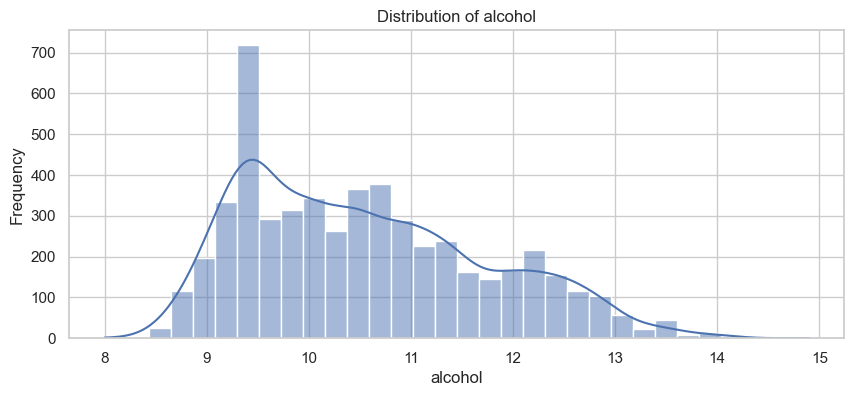

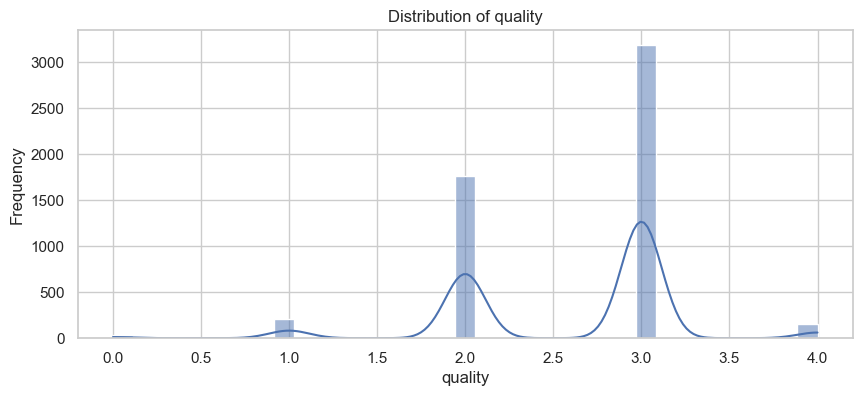

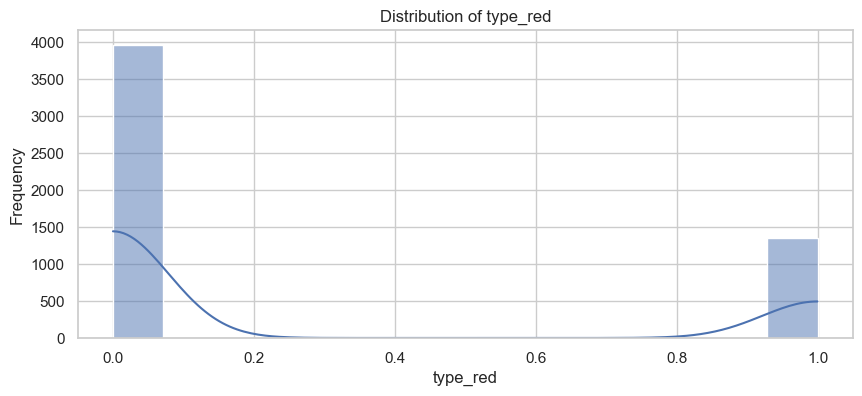

In [6]:
# Display distribution of each feature

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Iterate over each column to create a separate plot
for column in wine_df.columns:
    plt.figure(figsize=(10, 4))  # Adjust the size of the plot
    sns.histplot(wine_df[column], kde=True)  # Histogram with density plot (KDE)

    plt.title(f'Distribution of {column}')  # Set title
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label
    plt.show()

## Apply SMOTE

In [7]:
from imblearn.over_sampling import SMOTE

X = wine_df.drop("quality", axis=1)
y = wine_df["quality"]

minority_class_size = y.value_counts().min()
n_neighbors = min(minority_class_size - 1, 5)
smote = SMOTE(k_neighbors=n_neighbors)

# Resample training data
X_resampled, y_resampled = smote.fit_resample(X, y)

wine_df = pd.DataFrame(X_resampled, columns=wine_df.columns)
wine_df['quality'] = y_resampled

## EDA after SMOTE

In [9]:
wine_df["quality"].value_counts()

3    3184
2    3184
4    3184
1    3184
0    3184
Name: quality, dtype: int64

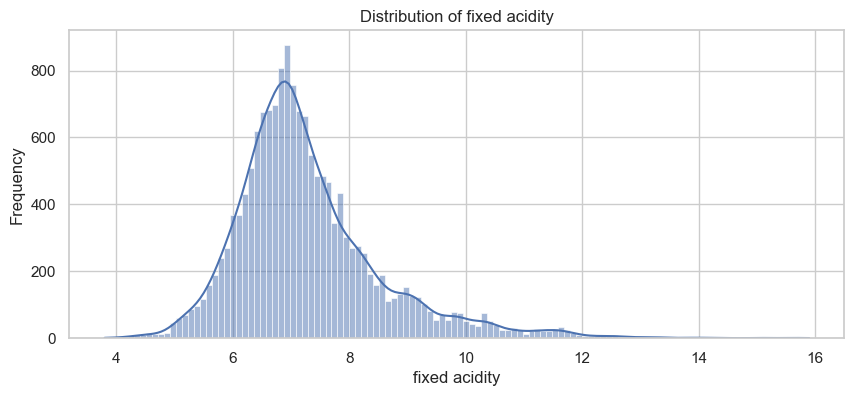

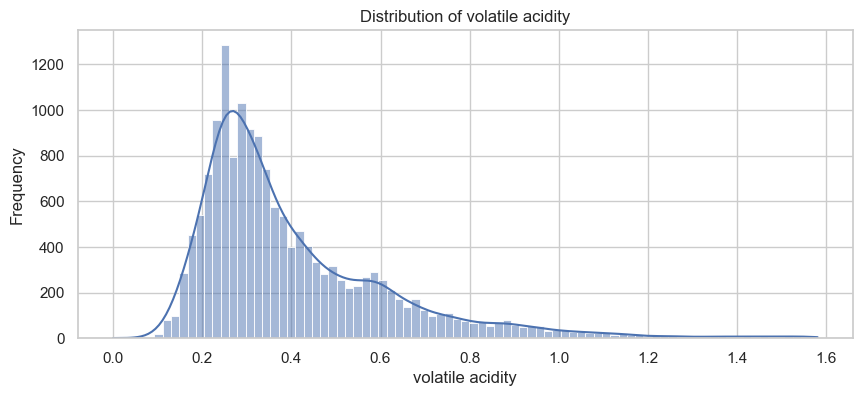

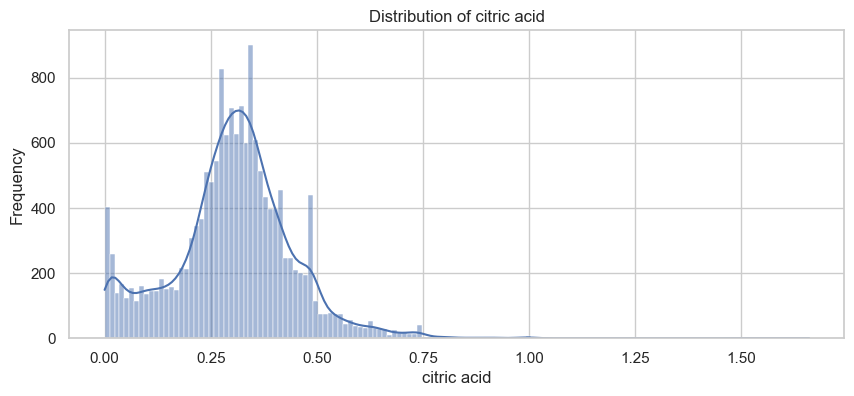

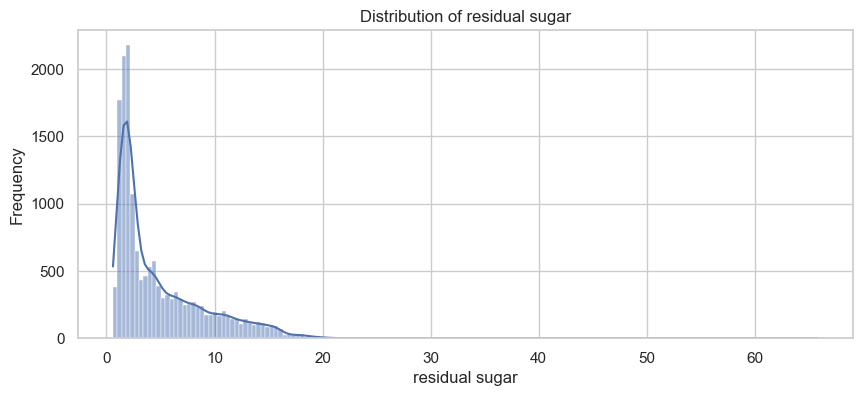

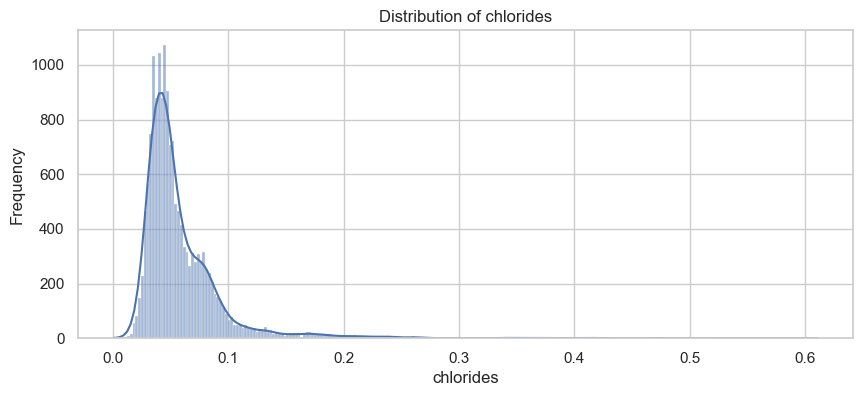

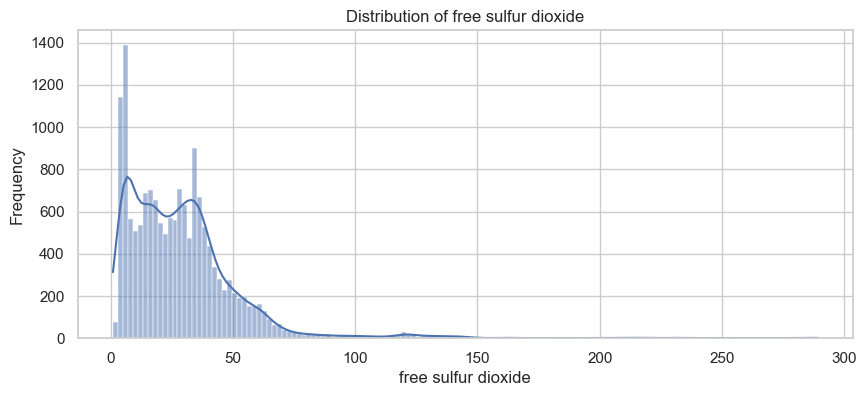

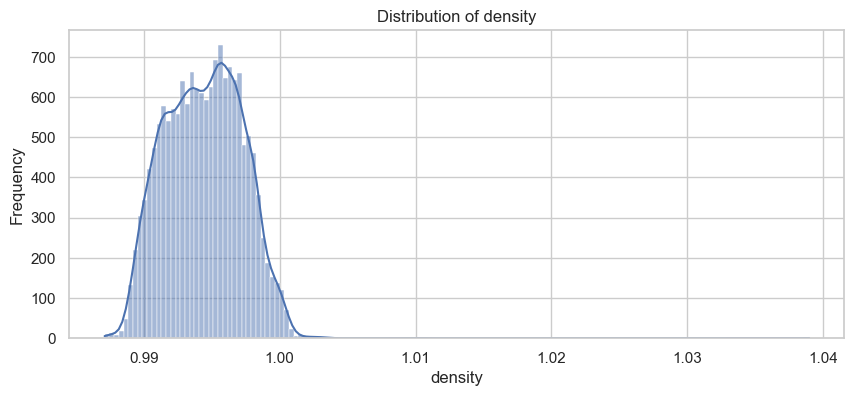

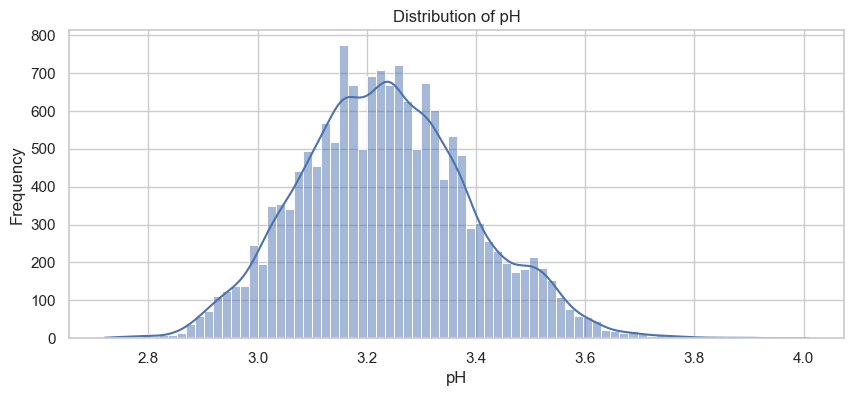

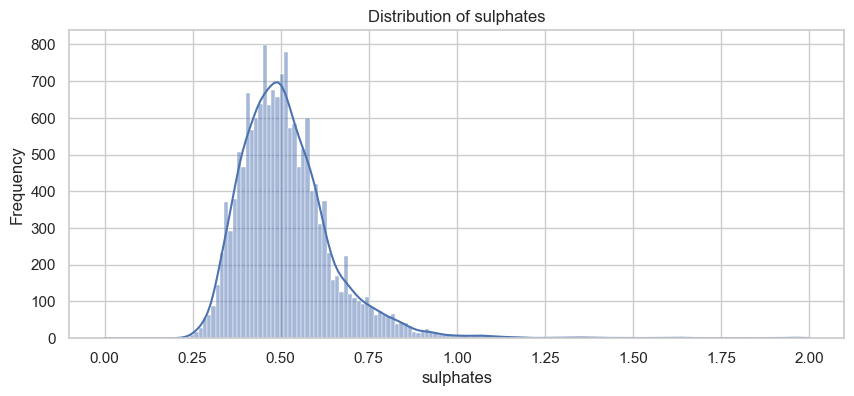

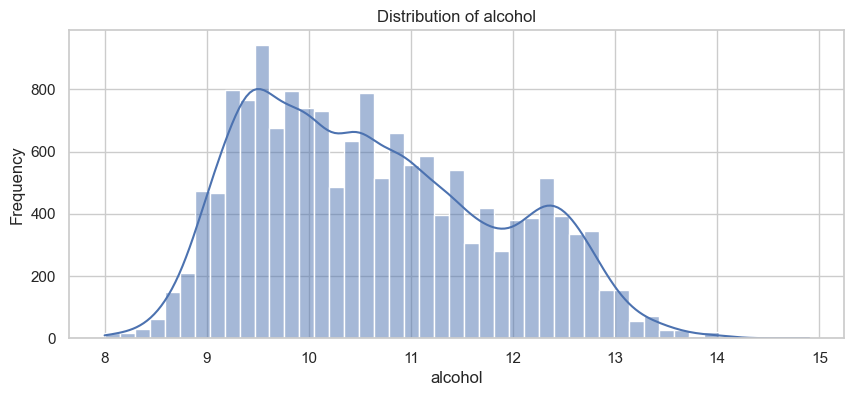

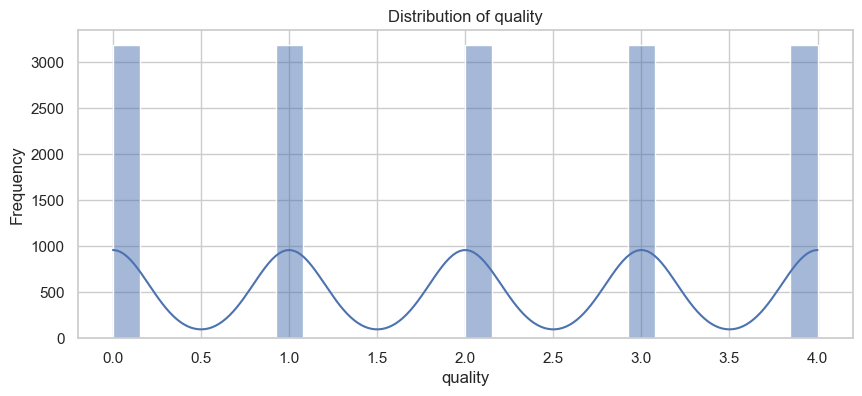

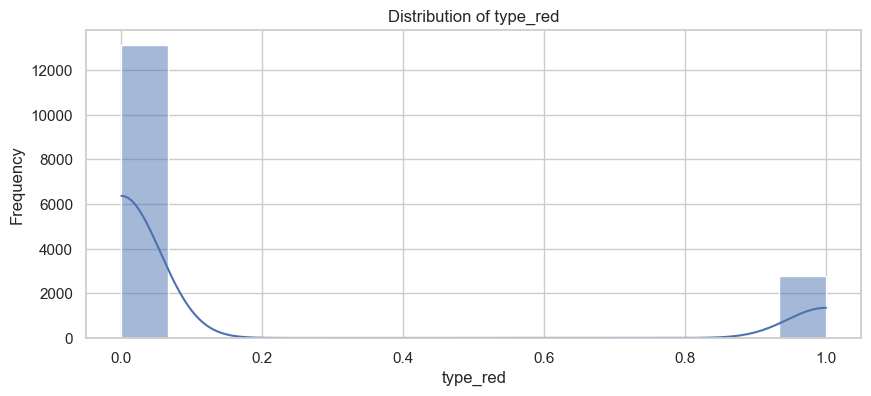

In [8]:
# Display distribution of each feature

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Iterate over each column to create a separate plot
for column in wine_df.columns:
    plt.figure(figsize=(10, 4))  # Adjust the size of the plot
    sns.histplot(wine_df[column], kde=True)  # Histogram with density plot (KDE)

    plt.title(f'Distribution of {column}')  # Set title
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label
    plt.show()